# Final project: DEQ implementation

### Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
!git clone https://github.com/LiableFish/dlsyscourse-project.git
%cd /content/drive/MyDrive/10714/dlsyscourse-project

!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install pybind11
!pip3 install tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714
fatal: destination path 'dlsyscourse-project' already exists and is not an empty directory.
/content/drive/MyDrive/10714/dlsyscourse-project
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-tb2l20jq
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-tb2l20jq
  Resolved https://github.com/dlsys10714/mugrade.git to commit 98609ee80ee24bf278455b48aa8d06bd3f5d0430
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!make

-- Found pybind11: /usr/local/lib/python3.8/dist-packages/pybind11/include (found version "2.10.1")
-- Found cuda, building cuda backend
Tue Jan  3 18:46:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+------------------------------

In [3]:
# Download the datasets you will be using for this assignment

import urllib.request
import os

!mkdir -p './data/ptb'
# Download Penn Treebank dataset
ptb_data = "https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb."
for f in ['train.txt', 'test.txt', 'valid.txt']:
    if not os.path.exists(os.path.join('./data/ptb', f)):
        urllib.request.urlretrieve(ptb_data + f, os.path.join('./data/ptb', f))

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

In [3]:
import sys
sys.path.append('./python')
sys.path.append('./apps')

In [4]:
import numpy as np

In [5]:
import needle as ndl

In [6]:
!pytest tests/test_fixed_point.py

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content/drive/MyDrive/10714/dlsyscourse-project, inifile:
plugins: typeguard-2.7.1

========================= no tests ran in 0.01 seconds =========================
ERROR: file not found: tests/test_fixed_point.py



In [7]:
device = ndl.cuda()

In [8]:
train_dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
test_dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=False)

In [9]:
train_dataloader = ndl.data.DataLoader(
         dataset=train_dataset,
         batch_size=128,
         shuffle=True,
)

test_dataloader = ndl.data.DataLoader(
         dataset=test_dataset,
         batch_size=128,
         shuffle=False,
)

In [10]:
X, _ = next(iter(train_dataloader))
X = ndl.Tensor(X, device=device)

In [11]:
from simple_training import train_cifar10, evaluate_cifar10

In [12]:
def _train(model, n_epochs: int = 10, batch_size: int = 128):
    train_dataloader = ndl.data.DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
    )

    test_dataloader = ndl.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
    )
    train_cifar10(
        model,
        train_dataloader,
        n_epochs=n_epochs,
        optimizer=ndl.optim.Adam,
        lr=0.001, 
        weight_decay=0.001,
    )
    evaluate_cifar10(model, test_dataloader)

### Training "tanh" model

In [13]:
from models import TanhLinearDEQ

In [14]:
tanh_model = TanhLinearDEQ(
    in_features=3072,
    hidden_size=128,
    n_classes=10,
    device=device,
    use_deq=False,
    depth=10,
)

In [15]:
tanh_deq_model = TanhLinearDEQ(
    in_features=3072,
    hidden_size=128,
    n_classes=10,
    device=device,
    use_deq=True,
    solver=ndl.solver.ForwardIteration(max_iter=100, debug=True),
)

In [16]:
len(tanh_model.parameters())

14

In [17]:
len(tanh_deq_model.parameters())

5

In [19]:
%%time
tanh_model(X).shape

CPU times: user 3.06 ms, sys: 0 ns, total: 3.06 ms
Wall time: 3.07 ms


(32, 10)

In [20]:
%%time
tanh_deq_model(X).shape

CPU times: user 148 ms, sys: 1.37 ms, total: 149 ms
Wall time: 148 ms


(32, 10)

In [21]:
_train(tanh_model)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.30428 loss: [1.9470556] time: 9.130s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.37008 loss: [1.7552787] time: 8.955s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.39378 loss: [1.6946154] time: 8.871s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.41 loss: [1.6547947] time: 9.096s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.41694 loss: [1.6279236] time: 8.927s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.42612 loss: [1.6103007] time: 8.905s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.4344 loss: [1.5817609] time: 9.027s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.44066 loss: [1.5610818] time: 10.021s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8/9 accuracy: 0.44242 loss: [1.555635] time: 9.015s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9/9 accuracy: 0.44964 loss: [1.542408] time: 8.880s


  0%|          | 0/78 [00:00<?, ?it/s]

accuracy: 0.4256 loss: [1.5905184]


In [22]:
_train(tanh_deq_model)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.28348 loss: [1.9913936] time: 22.858s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.35292 loss: [1.8062675] time: 22.385s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.37452 loss: [1.7442976] time: 21.453s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.38734 loss: [1.7104509] time: 20.872s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.39546 loss: [1.6827159] time: 21.845s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.4017 loss: [1.6627396] time: 23.386s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.4087 loss: [1.6406089] time: 25.992s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.41504 loss: [1.6259427] time: 29.362s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8/9 accuracy: 0.42212 loss: [1.6112707] time: 30.440s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9/9 accuracy: 0.42524 loss: [1.5983632] time: 33.316s


  0%|          | 0/78 [00:00<?, ?it/s]

accuracy: 0.4065 loss: [1.6448836]


In [25]:
import matplotlib.pyplot as plt

In [26]:
history = tanh_deq_model.deq.fixed_op.history

In [35]:
import numpy as np
np.array([meta.n_iter for meta in history]).mean()

9.87719298245614

Text(0, 0.5, 'n_iter')

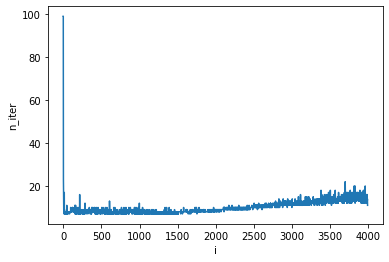

In [36]:
plt.plot(range(len(history)), [meta.n_iter for meta in history])
plt.xlabel("i")
plt.ylabel("n_iter")

Text(0, 0.5, 'mean norm')

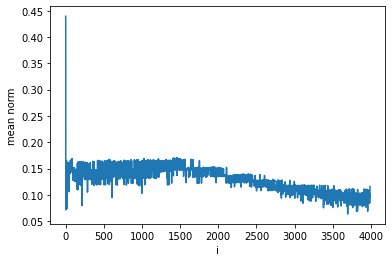

In [38]:
plt.plot(range(len(history)), [np.mean(meta.norms) for meta in history])
plt.xlabel("i")
plt.ylabel("mean norm")

### Training "ResNet" model

In [13]:
from models import ResNetDEQ

In [14]:
resnet_model = ResNetDEQ(
    in_channels=3,
    out_channels=16,
    hidden_size=32,
    kernel_size=3,
    n_classes=10,
    device=device,
    use_deq=False,
    depth=5,
)

In [29]:
resnet_deq_model = ResNetDEQ(
    in_channels=3,
    out_channels=16,
    hidden_size=32,
    kernel_size=3,
    n_classes=10,
    device=device,
    use_deq=True,
    solver=ndl.solver.ForwardIteration(max_iter=1000, debug=True),
)

In [16]:
len(resnet_model.parameters())

44

In [17]:
len(resnet_deq_model.parameters())

12

In [19]:
%%time
resnet_model(X).shape

CPU times: user 64.7 ms, sys: 22.1 ms, total: 86.8 ms
Wall time: 86.5 ms


(128, 10)

In [30]:
%%time
resnet_deq_model(X).shape

CPU times: user 20.1 s, sys: 620 ms, total: 20.7 s
Wall time: 23 s


(128, 10)

In [78]:
from models import ConvBN

class ResNetDEQLayer(ndl.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_size: int,
        kernel_size: int,
        device=None, 
        dtype="float32",
):
        super().__init__()
        self.device = device
        self.dtype = dtype
        self.convs = ndl.nn.Sequential(
            ConvBN(in_channels, hidden_size, kernel_size, 1, bias=False, device=device, dtype=dtype), 
            #ConvBN(hidden_size, in_channels, kernel_size, 1, bias=False, device=device, dtype=dtype),
        )
        self.relu = ndl.nn.ReLU()
        
    def forward(self, Z: ndl.Tensor, X: ndl.Tensor) -> ndl.Tensor:
        return self.relu(self.convs(Z) + X)

In [79]:


class ResNetDEQ(ndl.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_size: int,
        kernel_size: int,
        n_classes: int,
        device=None, 
        dtype="float32",
        use_deq: bool = False,
        depth: int = 50,
        solver: ndl.solver.BaseSolver = ndl.solver.ForwardIteration(),
    ):
        self.device = device
        self.dtype = dtype
        self.use_deq = use_deq
        self.conv = ndl.nn.Conv(in_channels, out_channels, kernel_size, stride=4, device=device, dtype=dtype)
        if self.use_deq:
            self.deq = ndl.nn.DEQ(
                ResNetDEQLayer(out_channels, hidden_size, kernel_size, device=device, dtype=dtype),
                solver,
            )
        else:
            self.layers = [
                ResNetDEQLayer(out_channels, hidden_size, kernel_size, device=device, dtype=dtype)
                for _ in range(depth)
            ]
        self.classification_layer = ndl.nn.Linear(out_channels * 8 * 8, n_classes, device=device)
        self.flatten = ndl.nn.Flatten()

    def forward(self, X: ndl.Tensor) -> ndl.Tensor:
        X = self.conv(X)

        if self.use_deq:
            Z = self.deq(X)
        else:
            Z = ndl.init.zeros_like(X)
            for layer in self.layers:
                Z = layer(Z, X)     
       
        return self.classification_layer(self.flatten(Z))


In [80]:
resnet_deq_model = ResNetDEQ(
    in_channels=3,
    out_channels=16,
    hidden_size=16,
    kernel_size=3,
    n_classes=10,
    device=device,
    use_deq=True,
    solver=ndl.solver.ForwardIteration(max_iter=100, debug=True),
)

In [81]:
%%time
resnet_deq_model(X).shape

CPU times: user 1.74 s, sys: 19.9 ms, total: 1.76 s
Wall time: 1.76 s


(128, 10)

In [82]:
resnet_deq_model.deq.fixed_op.history[0].n_iter

99

In [21]:
_train(resnet_model, batch_size=32)

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.40802 loss: [1.6348406] time: 215.934s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.50228 loss: [1.3721608] time: 211.115s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.54388 loss: [1.2636566] time: 209.761s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.57278 loss: [1.1903858] time: 208.492s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.60168 loss: [1.120579] time: 208.393s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.61888 loss: [1.0684779] time: 207.029s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.6348 loss: [1.024518] time: 206.555s


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.65042 loss: [0.98667026] time: 205.484s


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function Value.__del__ at 0x7ff2622bbc10>
Traceback (most recent call last):
  File "/content/drive/MyDrive/10714/dlsyscourse-project/./python/needle/autograd.py", line 110, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [89]:
np.random.seed(2)
_train(resnet_deq_model, batch_size= 128)

  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [90]:
import matplotlib.pyplot as plt

In [91]:
history = resnet_deq_model.deq.fixed_op.history

In [92]:
import numpy as np
np.array([meta.n_iter for meta in history]).mean()

99.0

Text(0, 0.5, 'n_iter')

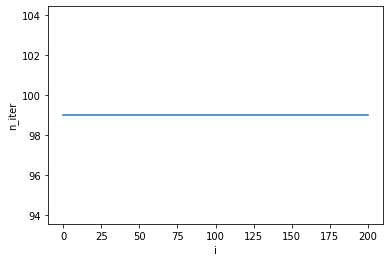

In [93]:
plt.plot(range(len(history)), [meta.n_iter for meta in history])
plt.xlabel("i")
plt.ylabel("n_iter")

Text(0, 0.5, 'mean norm')

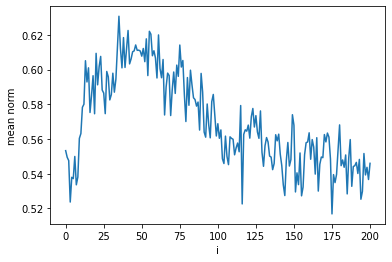

In [94]:
plt.plot(range(len(history)), [np.mean(meta.norms) for meta in history])
plt.xlabel("i")
plt.ylabel("mean norm")